In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 500)


In [3]:
def get_data_by_variable(variable_id : int) -> pd.DataFrame:
    headers = {
        'format': 'application/json',
        'lang': 'pl',
        'X-ClientId': '54f60e5f-cb69-4b70-fc64-08d9e6308fac',
    }

    query_arguments = {
        'page-size' : '100',
        'unit-level': '5'
    }

    query_string = '&'.join(['='.join([key, value]) for key, value in query_arguments.items()])

    response = requests.get(f'https://bdl.stat.gov.pl/api/v1/data/by-variable/{variable_id}/?{query_string}', headers=headers)
    number_of_records = response.json()['totalRecords']
    data = {}

    for i in range(number_of_records // 100 + 1):
        api_call = requests.get(f'https://bdl.stat.gov.pl/api/v1/data/by-variable/{variable_id}/?{query_string}&page={i}', headers=headers)
        json = api_call.json()

        for result in json['results']:
            years = [row['year'] for row in result['values']]
            values = [row['val'] for row in result['values']]
            data[result['name']] = pd.Series(data=values, index=years)

    return pd.DataFrame.from_dict(data, orient='index')

## Założenia
W przygotowaniu indeksu atrakcyjności lokalizacji dla sklepów i wypożyczalni rowerowych zdecydowałem się na obliczaniu go na poziomie powiatów z uwagi na większą ilość zmiennych statystycznych w BDL na tym poziomie. W swojej analizie skupiam się na dancyh z ostatnich 5 lat (lata 2016-2020).

## Zmienne
nazwa zmiennej [id zmiennej]

### Sport
- kluby sportowe na 10 tys. ludnosci [1609348]

### Zarobki
- przeciętne miesięczne wynagrodzenia brutto w relacji do średniej krajowej (Polska=100) [64429]

### Ludnosc
- gminy bez miast na prawach powiatu ogółem 30.06 [199202]
- gminy bez miast na prawach powiatu ogółem 31.12 [199206]
- miasta na prawach powiatu ogółem 30.06 [199203]
- miasta na prawach powiatu ogółem 31.12 [199207]

### Turystyka
- udzielone noclegi na 1000 ludnosci ogółem [60298]
- turysci korzystający z noclegow na 1000 ludnosci ogółem [60297]

### Transport
- ścieżki rowerowe ogółem [288080]




# Ludność

Dane są aktualizowane co pół roku. Ponadto dane są podzielone na powiaty i miasta na prawach powiatu.

In [4]:
ludnosc_gminy_czerwiec = get_data_by_variable(199202)
ludnosc_miasta_czerwiec = get_data_by_variable(199203)

miasta = ludnosc_miasta_czerwiec.index.to_series().filter(regex='m\\.')
nie_miasta = set(ludnosc_miasta_czerwiec.index).difference(miasta)

ludnosc_gminy_czerwiec.drop(index=miasta, inplace=True)
ludnosc_miasta_czerwiec.drop(index=nie_miasta, inplace=True)

ludnosc_czerwiec = pd.concat([ludnosc_miasta_czerwiec, ludnosc_gminy_czerwiec])

In [5]:
ludnosc_gminy_grudzien = get_data_by_variable(199206)
ludnosc_miasta_grudzien = get_data_by_variable(199207)

ludnosc_gminy_grudzien.drop(index=miasta, inplace=True)
ludnosc_miasta_grudzien.drop(index=nie_miasta, inplace=True)

ludnosc_grudzien = pd.concat([ludnosc_miasta_grudzien, ludnosc_gminy_grudzien])

Różnica między danymi z grudnia i czerwca zmienia się z roku na rok. Nie wygląda na to, żeby to, które dane wybierzemy miało duży wpływ na wyniki. Zdecydowałem się na dane z czerwca.

2011_diff     32.292683
2012_diff     -2.891599
2013_diff    -19.332432
2014_diff    -14.859459
2015_diff    -45.964865
2016_diff     16.862162
2017_diff     28.505405
2018_diff     -6.137838
2019_diff    -11.129730
2020_diff   -237.051351
dtype: float64


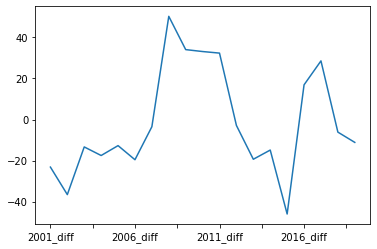

In [6]:
ludnosc_razem = pd.merge(ludnosc_czerwiec, ludnosc_grudzien, left_index=True, right_index=True, suffixes=['_cze', '_gru'])

for year in ludnosc_czerwiec.columns:
    ludnosc_razem[f'{year}_diff'] = ludnosc_razem[f'{year}_gru'] - ludnosc_razem[f'{year}_cze']


srednie_roznice = ludnosc_razem.iloc[:, -20:].agg(np.mean, axis=0)
print(srednie_roznice.iloc[-10:])
srednie_roznice.iloc[:-1].plot(kind='line')
plt.show()

In [7]:
ludnosc = ludnosc_czerwiec.loc[:, '2016':]
ludnosc.dropna(inplace=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


# Zarobki
Dane obrazują średnie zarobki w powiacie w relacji do średniej krajowej
Jak widać na wykresie średnia płaca przez ostanie 5 lat co roku wzrasta. W związku z tym będziemy brali pod uwagę tylko pensje z roku 2020.

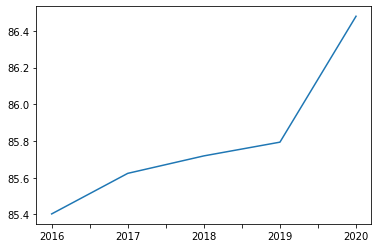

In [8]:
zarobki = get_data_by_variable(64429)
zarobki = zarobki.loc[:, '2016':]
zarobki.dropna(inplace=True)
zarobki.agg(np.mean, axis=0).plot(kind='line')
plt.show()

In [9]:
zarobki_2020 = zarobki.loc[:, '2020']

# Sport

In [10]:
kluby_sportowe = get_data_by_variable(1609348)

In [11]:
kluby_sportowe = kluby_sportowe.loc[:, '2016':]

kluby_lud = pd.merge(ludnosc[kluby_sportowe.columns], kluby_sportowe, left_index=True, right_index=True, suffixes=['_lud', '_ks'])

for year in kluby_sportowe.columns:
    kluby_lud[f'{year}_ogolnie'] = kluby_sportowe[year] * ludnosc[year] / 10_000

W ostatnim roku mial miejsce znaczny spadek liczby klubów sportowych. Jako wyznacznik użyję średnią ilość klubów z ostatnich 5 lat w regionie.

In [12]:
kluby_lud.iloc[:, -3:].agg(np.sum)

2016_ogolnie    14400.11221
2018_ogolnie    14294.23426
2020_ogolnie    13840.66556
dtype: float64

In [13]:
kluby_ogolnie_srednia = kluby_lud.iloc[:, -3:].agg(np.mean, axis=1)
kluby_ogolnie_srednia = kluby_ogolnie_srednia.astype(np.int64)
kluby_sportowe_10k_srednia = kluby_sportowe.agg(np.mean, axis=1)

# Turystyka

In [14]:
udzielone_noclegi = get_data_by_variable(60298)
turysci = get_data_by_variable(60297)

Dla zmiennej udzielone noclegi na 1000 mieszkańców wartości są wyższe, niż dla zmiennej liczba turystówn na 1000 mieszkańców. Pierwsza z nich prawdopodobnie bierze pod uwagę też osoby z danego regionu. Zależy mi na ruchu turystycznym, więc skupię się na drugiej zmiennej.

In [15]:
udzielone_noclegi.head().iloc[:, -10:]

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Powiat bocheński,932.78,827.44,826.89,891.86,895.30,907.85,1007.24,1039.66,1177.21,593.47
Powiat krakowski,486.41,503.22,443.07,445.74,636.70,881.37,863.59,825.19,841.10,344.74
Powiat miechowski,487.48,355.17,306.87,281.99,437.96,1251.99,1236.57,1375.65,1446.15,759.54
Powiat myślenicki,317.90,322.52,335.12,456.64,476.10,622.88,627.23,546.04,578.32,264.40
Powiat proszowicki,199.52,367.89,416.86,345.21,269.56,251.92,242.41,290.54,323.49,96.43


In [16]:
turysci.head().iloc[:, -10:]

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Powiat bocheński,597.29,573.68,492.85,568.83,529.20,543.68,611.13,584.81,718.90,255.16
Powiat krakowski,298.75,322.30,270.40,272.05,394.67,538.34,525.93,516.64,519.31,198.84
Powiat miechowski,293.99,238.27,217.27,198.66,263.63,627.51,627.91,696.05,696.82,332.19
Powiat myślenicki,124.35,137.19,145.22,208.58,234.22,293.38,312.68,304.96,303.87,145.22
Powiat proszowicki,115.53,250.98,292.92,274.98,214.33,162.92,139.51,167.75,196.74,62.40


In [17]:
turysci = turysci.loc[:, '2016':]
turysci.dropna(inplace=True)

In [18]:
turysci_ogolem = pd.DataFrame()

for year in turysci.columns:
    turysci_ogolem[year] = turysci[year] * ludnosc[year] / 1000

In [19]:
turysci_ogolem.agg(np.sum).astype(np.int64)

2016    29357805
2017    31203254
2018    33067150
2019    34811620
2020    17351127
dtype: int64

Widać duży spadek w 2020 roku. Jako wyznacznika użyjemy średniej z ostatnich 5 lat.

In [20]:
turysci_srednia = turysci_ogolem.agg(np.mean, axis=1)
turysci_srednia = turysci_srednia.astype(np.int64)

# Transport
Tutaj interesują nas tylko dane z 2020 roku.

In [21]:
sciezki_rowerowe = get_data_by_variable(288080)
sciezki_rowerowe.head()

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Powiat bocheński,1.7,3.3,3.3,4.0,4.9,9.4,11.7,12.9,13.2,28.5
Powiat krakowski,0.0,0.7,0.7,0.7,0.7,1.0,2.2,7.4,14.1,25.1
Powiat miechowski,0.0,0.5,0.5,0.5,0.5,0.5,0.5,8.3,14.3,14.3
Powiat myślenicki,1.1,1.1,4.5,4.5,4.6,4.6,4.5,4.5,8.0,12.5
Powiat proszowicki,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.2


In [22]:
sciezki_rowerowe = sciezki_rowerowe['2020']
sciezki_rowerowe.head()

Powiat bocheński      28.5
Powiat krakowski      25.1
Powiat miechowski     14.3
Powiat myślenicki     12.5
Powiat proszowicki     0.2
Name: 2020, dtype: float64

# Budowanie indeksów

In [23]:
dane = {
    'ludnosc' : ludnosc['2020'].astype(np.int64),
    'turysci_1k_mieszkancow': turysci.agg(np.sum, axis=1),
    'turysci_ogolem': turysci_srednia,
    'kluby_sportowe_10k_mieszkancow': kluby_sportowe_10k_srednia,
    'kluby_sportowe_ogolem': kluby_ogolnie_srednia,
    'zarobki': zarobki_2020,
    'sciezki_rowerowe': sciezki_rowerowe
}

dane_razem = pd.DataFrame(dane)

In [24]:
dane_razem.head()

,ludnosc,turysci_1k_mieszkancow,turysci_ogolem,kluby_sportowe_10k_mieszkancow,kluby_sportowe_ogolem,zarobki,sciezki_rowerowe
Powiat aleksandrowski,55007,13489.56,149020,4.133333,22,74.9,27.4
Powiat augustowski,57908,5484.42,64166,4.100000,23,90.7,57.1
Powiat bartoszycki,56891,1281.92,14895,2.433333,14,83.1,16.2
Powiat bełchatowski,112702,2279.32,51469,4.666667,52,126.8,137.0
Powiat bialski,110454,3641.75,81273,3.233333,36,77.1,53.6


Aby nasze łatwiej stworzyć indeksy, chciałbym, żeby nasze dane przyjmowały wartości między 0 a 1

In [25]:
def normalize(x: pd.Series) -> pd.Series:
    return (x - x.min()) / (x.max() - x.min())

In [26]:
dane_norm = pd.DataFrame(index=dane_razem.index)

for col in dane_razem.columns:
    dane_norm[col] = dane_razem[col].transform(normalize)

dane_norm.head()

,ludnosc,turysci_1k_mieszkancow,turysci_ogolem,kluby_sportowe_10k_mieszkancow,kluby_sportowe_ogolem,zarobki,sciezki_rowerowe
Powiat aleksandrowski,0.019845,0.196420,0.047601,0.414097,0.053221,0.052516,0.040527
Powiat augustowski,0.021480,0.079858,0.020496,0.409692,0.056022,0.225383,0.084455
Powiat bartoszycki,0.020907,0.018666,0.004758,0.189427,0.030812,0.142232,0.023961
Powiat bełchatowski,0.052371,0.033189,0.016441,0.484581,0.137255,0.620350,0.202633
Powiat bialski,0.051104,0.053027,0.025961,0.295154,0.092437,0.076586,0.079278


Spójrzmy na nasze dane. Aby indeks miał równomierny rozkład, chcielibyśmy używać danych o rozkładzie zbliżonym do normalnego.

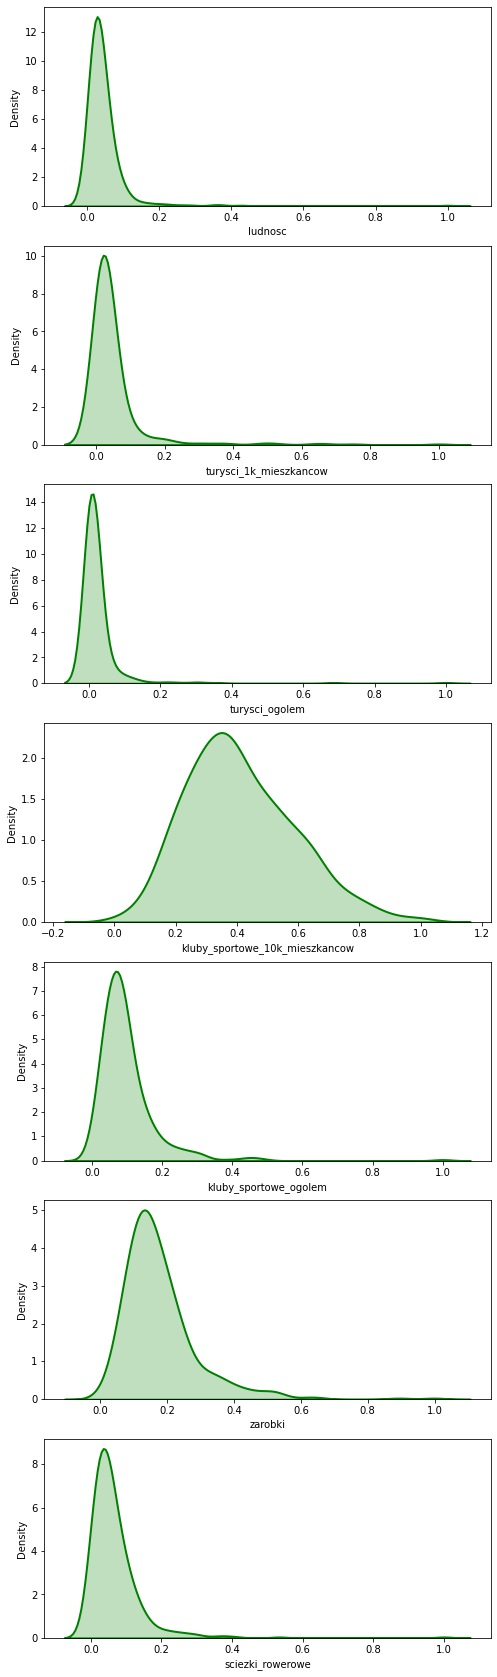

In [27]:
import warnings

fig, ax = plt.subplots(dane_norm.columns.size)

with warnings.catch_warnings(record=True):
    for i, col in enumerate(dane_norm.columns):
        sns.distplot(dane_norm[col], hist=False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 2},
                     color='green',
                     label=col,
                     ax=ax[i]
                     )

fig.set_figwidth(8)
fig.set_figheight(30)
plt.show()

Niestety zmienne nie są rozłożone w sposób normalny. Możemy temu zaradzić używając tranformacji Box Cox. Następnie będziemy musieli jeszcze raz dokonać normalizacji.

In [28]:
from scipy.stats import boxcox

dane_trans = pd.DataFrame(index=dane_razem.index)

for col in dane_razem.columns:
    dane_trans[col] = boxcox(dane_norm[col] + 1)[0] # dodaję 1, aby uniknąć wartości zerowych
    dane_trans[col] = dane_trans[col].transform(normalize)

dane_trans.head()

,ludnosc,turysci_1k_mieszkancow,turysci_ogolem,kluby_sportowe_10k_mieszkancow,kluby_sportowe_ogolem,zarobki,sciezki_rowerowe
Powiat aleksandrowski,0.322493,0.962124,0.804429,0.565263,0.382832,0.248271,0.366196
Powiat augustowski,0.343665,0.753988,0.509322,0.560808,0.397910,0.683991,0.605760
Powiat bartoszycki,0.336323,0.286497,0.153430,0.301554,0.246021,0.526257,0.237984
Powiat bełchatowski,0.636285,0.448968,0.435732,0.633375,0.698297,0.949190,0.879922
Powiat bialski,0.627497,0.610587,0.593173,0.435676,0.560983,0.337818,0.583490


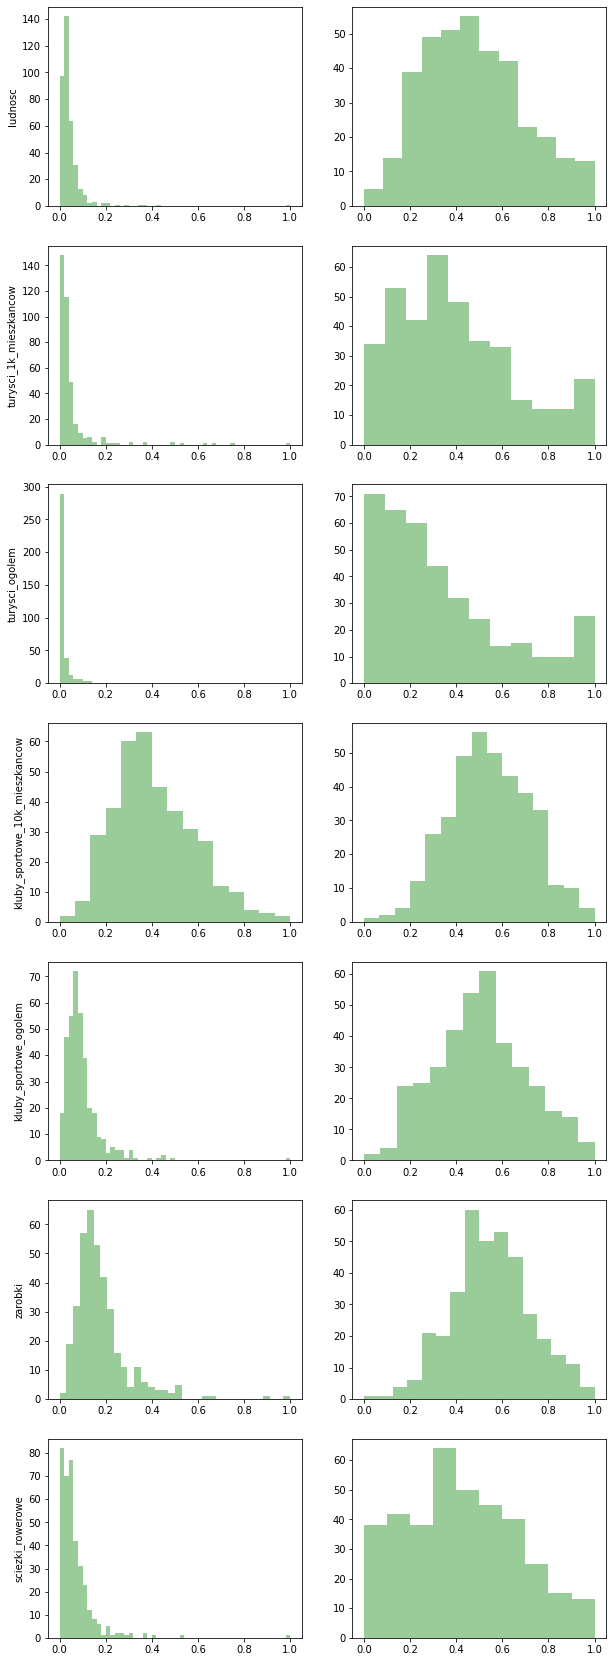

In [29]:
fig, ax = plt.subplots(dane_razem.columns.size, 2)

with warnings.catch_warnings(record=True):
    for i, col in enumerate(dane_norm.columns):
        sns.distplot(dane_norm[col], hist=True, kde=False, color='green', ax=ax[i, 0])
        sns.distplot(dane_trans[col], hist=True, kde=False, color='green', ax=ax[i, 1])

        ax[i, 0].set_ylabel(col)
        ax[i, 0].set_xlabel('')
        ax[i, 1].set_ylabel('')
        ax[i, 1].set_xlabel('')

fig.set_figwidth(10)
fig.set_figheight(30)
plt.show()

Rozkłady naszych zmiennych wyglądają dużo lepiej. Przejdźmy do samych indeksów.

### Wypożyczalnie
Dla wypożyczalni zdecydowałem się na użycie informacji o liczbie turystów na 1000 mieszkańców, o ścieżkach rowerowych oraz o zarobkach. Średnie zarobki mają ujemny wpływ na pozycje w indeksie, ze względu na niższy koszt wypożyczenia roweru, sprzyjający wypożyczeniu. Współczynniki zależą od ważności, którą wybrałem samemu


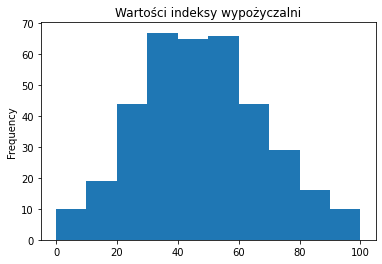

,ludnosc,turysci_1k_mieszkancow,turysci_ogolem,kluby_sportowe_10k_mieszkancow,kluby_sportowe_ogolem,zarobki,sciezki_rowerowe
Powiat pucki,0.522243,0.991948,0.976616,0.533552,0.528219,0.590629,0.838691
Powiat nowotarski,0.840304,0.815708,0.936009,0.699777,0.894172,0.388438,0.818200
Powiat kamieński,0.259118,0.999227,0.964046,0.872146,0.516705,0.367305,0.552119
Powiat kołobrzeski,0.480407,0.999881,0.999135,0.582844,0.528219,0.518427,0.671302
Powiat koniński,0.697053,0.721039,0.757742,0.481126,0.645123,0.286484,0.712785


In [30]:
wypozyczalnie = (1.3 * dane_trans.turysci_1k_mieszkancow + 1.5 * dane_trans.sciezki_rowerowe - 1.2 * dane_trans.zarobki).transform(normalize) * 100
wypozyczalnie.plot(kind='hist')
plt.title('Wartości indeksu wypożyczalni')
plt.show()
dane_trans.loc[wypozyczalnie.nlargest(5).index, :]

### Sklepy
Tutaj biorę pod uwagę dane o populacji, ilosci scieżek rowerowych, zarobkach oraz klubach sportowych mieszkańców w danym powiecie. Indeks preferuje duże miasta.

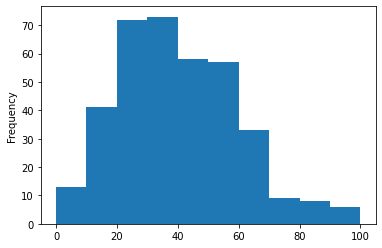

,ludnosc,kluby_sportowe_10k_mieszkancow,kluby_sportowe_ogolem,zarobki,sciezki_rowerowe
Powiat m. st. Warszawa,1.000000,0.136564,1.000000,0.648796,1.000000
Powiat m.Kraków,0.429127,0.171806,0.487395,0.517505,0.373909
Powiat m.Wrocław,0.351779,0.207048,0.450980,0.449672,0.533057
Powiat m.Poznań,0.289791,0.255507,0.431373,0.442013,0.408224
Powiat m.Gdańsk,0.254665,0.176211,0.294118,0.518600,0.300251


In [31]:
sklepy = (dane_trans.ludnosc + 1.5 * dane_trans.sciezki_rowerowe + 1.8 * dane_trans.zarobki + 1.1 * dane_trans.kluby_sportowe_ogolem).transform(normalize) * 100
sklepy.plot(kind='hist')
plt.show()

dane_norm.loc[sklepy.nlargest(5).index, ['ludnosc', 'kluby_sportowe_10k_mieszkancow', 'kluby_sportowe_ogolem', 'zarobki', 'sciezki_rowerowe']]